In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%run model_by_model_analysis_helper.py

In [4]:
# save_output_path = '/export/data1/cchristo/diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_2_mode_year_mean_bootstrap_1yr_final_means/2000-06_2016-06_precip.nc'

save_output_path = '/export/data1/cchristo/diurnal_analysis_results/GPM_final_paper_v1/combined/'

In [5]:

# gpm_full_path = '/export/data1/cchristo/diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_2_mode_year_mean_bootstrap_1yr_final/2000-06_2016-06_precip.nc'
# ds_gpm = xr.open_dataset(gpm_full_path)
gpm_full_path = '/export/data1/cchristo/diurnal_analysis_results/GPM_final_paper_v1/seperate/*.nc'
ds_gpm = xr.open_mfdataset(gpm_full_path, combine = 'nested', concat_dim='bootstrap_id')
ds_gpm = ds_gpm.assign_coords({'bootstrap_id' :np.arange(0,200)})
ds_gpm.load()

<xarray.Dataset>
Dimensions:       (bootstrap_id: 200, lat: 120, lon: 288)
Coordinates:
  * bootstrap_id  (bootstrap_id) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * lon           (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
Data variables:
    ampl_season   (bootstrap_id, lat, lon) float64 0.013 0.01386 ... 0.008561
    phase_season  (bootstrap_id, lat, lon) float64 12.31 13.08 ... 22.23 0.812

In [7]:
ds_gpm_mean = ds_gpm.mean(dim = 'bootstrap_id')
ds_gpm_std = ds_gpm.std(dim = 'bootstrap_id')['ampl_season']

In [7]:
# ds_gpm_std.sel(lat = lat_, lon = lon_, method = 'nearest').values

0.0037614802855297814


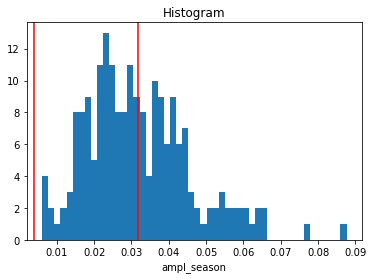

In [54]:
lat_ = 29
lon_ = 200
mm = ds_gpm_mean.sel(lat = lat_, lon = lon_, method = 'nearest')['ampl_season'].values
mm_std = mm - 2*ds_gpm_std.sel(lat = lat_, lon = lon_, method = 'nearest').values
_ = ds_gpm.sel(lat = lat_, lon = lon_, method = 'nearest')['ampl_season'].plot.hist(bins = 50)
plt.axvline(mm, c = 'r')
plt.axvline(mm_std, c = 'r')
print(mm_std)

In [8]:
# find circular means of phase across bootstrap samples for each gridcell
phase_ens_mean = xr.apply_ufunc(phase_circmean, 
                               ds_gpm['phase_season'], 
                               input_core_dims = [["bootstrap_id"]],
                               vectorize = True)
ds_gpm_mean['phase_season'] = phase_ens_mean

In [7]:
# param_dist = ds_gpm.sel(lat = 5, lon = 150, method = 'nearest')['phase_season'].values
# _ = plt.hist(param_dist, bins = 20)
# sns.distplot(param_dist, fit=scipy.stats.lognorm)
# lognorm_0_cdf(param_dist)

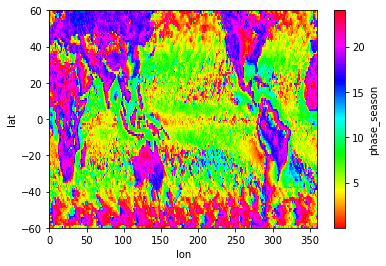

In [9]:
ds_gpm_mean['phase_season'].plot(cmap = plt.get_cmap('hsv'))

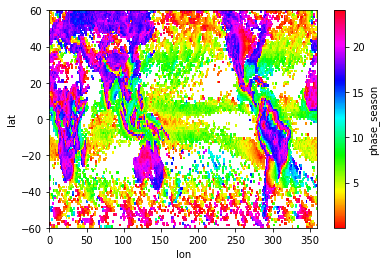

In [16]:
ds_gpm_mean.where(ds_gpm_mean['ampl_season'] - 2*ds_gpm_std >= 0)['phase_season'].plot(cmap = plt.get_cmap('hsv'))

In [17]:
CI_mask = xr.where(ds_gpm_mean['ampl_season'] - 2*ds_gpm_std >= 0, True, False)
CI_mask.name = 'CI_mask'
ds_gpm_mean['CI_mask'] = CI_mask

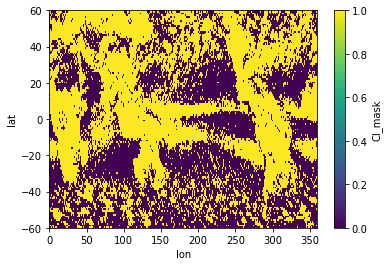

In [19]:
ds_gpm_mean['CI_mask'].plot()

In [21]:
# ds_gpm_mean['phase_season'].plot()

# ds_gpm_mean['CI_mask'].plot()
# ds_gpm_mean['CI_mask'].plot()

In [20]:
save_output_path
ds_gpm_mean.to_netcdf(save_output_path + 'bootstrap_10day_mean_CI_2sig.nc')